# Word2Vec

Using only the raw text, we'll derive and explore the semantic properties of its words.

## Imports

Python code in one module gains access to the code in another module by the process of importing it. The import statement is the most common way of invoking the import machinery, but it is not the only way.

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/keno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/keno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("txtdata/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['txtdata/01_aufbauhaus.txt',
 'txtdata/02_bauhausbuch1.txt',
 'txtdata/03_staatlichesbauhaus.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'txtdata/01_aufbauhaus.txt'...
Corpus is now 41834 characters long

Reading 'txtdata/02_bauhausbuch1.txt'...
Corpus is now 48291 characters long

Reading 'txtdata/03_staatlichesbauhaus.txt'...
Corpus is now 56550 characters long



**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
# convert into a list of words
# remove unnnecessary, split into words, no hyphens
# list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-ZäÄöÖüÜß]"," ", raw)
    clean = re.sub("[äÄ]", "ae", clean)
    clean = re.sub("[öÖ]", "oe", clean)
    clean = re.sub("[üÜ]", "ue", clean)
    clean = re.sub("[ß]", "ss", clean)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Solange aber die Wirtschaft, die Maschine Selbstzweck sind, anstatt Mittel, die Geisteskräfte zunehmend von mechanischer Arbeitslast zu befreien, bleibt der Einzelne unfrei und die Gesellschaft kann sich nicht ordnen.
['Solange', 'aber', 'die', 'Wirtschaft', 'die', 'Maschine', 'Selbstzweck', 'sind', 'anstatt', 'Mittel', 'die', 'Geisteskraefte', 'zunehmend', 'von', 'mechanischer', 'Arbeitslast', 'zu', 'befreien', 'bleibt', 'der', 'Einzelne', 'unfrei', 'und', 'die', 'Gesellschaft', 'kann', 'sich', 'nicht', 'ordnen']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 7,699 tokens


## Train Word2Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2019-10-25 20:52:56,133 : INFO : collecting all words and their counts
2019-10-25 20:52:56,135 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-25 20:52:56,140 : INFO : collected 2502 word types from a corpus of 7699 raw words and 328 sentences
2019-10-25 20:52:56,141 : INFO : Loading a fresh vocabulary
2019-10-25 20:52:56,144 : INFO : effective_min_count=3 retains 482 unique words (19% of original 2502, drops 2020)
2019-10-25 20:52:56,145 : INFO : effective_min_count=3 leaves 5267 word corpus (68% of original 7699, drops 2432)
2019-10-25 20:52:56,149 : INFO : deleting the raw counts dictionary of 2502 items
2019-10-25 20:52:56,152 : INFO : sample=0.001 downsamples 70 most-common words
2019-10-25 20:52:56,153 : INFO : downsampling leaves estimated 3408 word corpus (64.7% of prior 5267)
2019-10-25 20:52:56,155 : INFO : estimated required memory for 482 words and 300 dimensions: 1397800 bytes
2019-10-25 20:52:56,155 : INFO : resetting layer weights


In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 482


**Start training, this might take a minute or two...**

In [20]:
thrones2vec.train(sentences, total_words=token_count, epochs = 100 )

2019-10-25 20:52:56,325 : INFO : training model with 4 workers on 482 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-10-25 20:52:56,336 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:56,338 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:56,339 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:56,368 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:56,369 : INFO : EPOCH - 1 : training on 7699 raw words (3360 effective words) took 0.0s, 101420 effective words/s
2019-10-25 20:52:56,374 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:56,374 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:56,375 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:56,404 : INFO : worker thread finished; awaiting finish of 0 more t

2019-10-25 20:52:56,979 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:57,003 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:57,005 : INFO : EPOCH - 17 : training on 7699 raw words (3393 effective words) took 0.0s, 107699 effective words/s
2019-10-25 20:52:57,010 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:57,011 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:57,012 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:57,041 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:57,042 : INFO : EPOCH - 18 : training on 7699 raw words (3422 effective words) took 0.0s, 101332 effective words/s
2019-10-25 20:52:57,048 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:57,053 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-

2019-10-25 20:52:57,618 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:57,619 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:57,619 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:57,648 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:57,649 : INFO : EPOCH - 34 : training on 7699 raw words (3385 effective words) took 0.0s, 105462 effective words/s
2019-10-25 20:52:57,655 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:57,656 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:57,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:57,685 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:57,686 : INFO : EPOCH - 35 : training on 7699 raw words (3394 effective words) took 0.0s, 103208 effective words/s
2019-10-

2019-10-25 20:52:58,240 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:58,241 : INFO : EPOCH - 50 : training on 7699 raw words (3450 effective words) took 0.0s, 97215 effective words/s
2019-10-25 20:52:58,246 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:58,247 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:58,247 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:58,277 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:58,278 : INFO : EPOCH - 51 : training on 7699 raw words (3380 effective words) took 0.0s, 100981 effective words/s
2019-10-25 20:52:58,283 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:58,293 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:58,294 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-2

2019-10-25 20:52:58,841 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:58,842 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:58,869 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:58,869 : INFO : EPOCH - 67 : training on 7699 raw words (3403 effective words) took 0.0s, 109592 effective words/s
2019-10-25 20:52:58,874 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:58,875 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:58,877 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:58,904 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:58,905 : INFO : EPOCH - 68 : training on 7699 raw words (3440 effective words) took 0.0s, 107795 effective words/s
2019-10-25 20:52:58,909 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-

2019-10-25 20:52:59,457 : INFO : EPOCH - 83 : training on 7699 raw words (3431 effective words) took 0.0s, 93986 effective words/s
2019-10-25 20:52:59,463 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:59,464 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:59,464 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:59,493 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:52:59,494 : INFO : EPOCH - 84 : training on 7699 raw words (3434 effective words) took 0.0s, 99634 effective words/s
2019-10-25 20:52:59,501 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-25 20:52:59,503 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-25 20:52:59,504 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:52:59,528 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25

2019-10-25 20:53:00,035 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-25 20:53:00,064 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-25 20:53:00,065 : INFO : EPOCH - 100 : training on 7699 raw words (3447 effective words) took 0.0s, 102263 effective words/s
2019-10-25 20:53:00,066 : INFO : training on a 769900 raw words (340857 effective words) took 3.7s, 91174 effective words/s


(340857, 769900)

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-10-25 20:53:00,183 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2019-10-25 20:53:00,185 : INFO : not storing attribute vectors_norm
2019-10-25 20:53:00,186 : INFO : not storing attribute cum_table
2019-10-25 20:53:00,201 : INFO : saved trained/thrones2vec.w2v


## Explore the trained model.

In [23]:
print(thrones2vec.most_similar('Wirtschaft', topn=5))

/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-10-25 20:53:00,358 : INFO : precomputing L2-norms of word weight vectors


[('Ausnutzung', 0.7126645445823669), ('Mitteln', 0.6176087856292725), ('bestimmt', 0.6033012270927429), ('Forderungen', 0.594092607498169), ('entscheidend', 0.5862294435501099)]


### Compress the word vectors into 2D space and plot them

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=3, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.wv.syn0

/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


**Train t-SNE, this could take a minute or two...**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1], coords[2])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "z"]
)

In [28]:
points.head(100)

,word,x,y,z
0,Die,-57.209652,72.341194,-85.091461
1,Idee,-92.229538,99.483673,-73.213020
2,der,570.903503,82.604378,470.273651
3,heutigen,-126.656082,-41.505161,-49.655975
4,Welt,-107.560295,-115.864342,-13.383244
...,...,...,...,...
95,ganzen,-41.123688,30.031334,-60.437313
96,Leben,-6.205709,-0.129103,-25.919806
97,Volkes,-3.125046,68.285217,-67.541283
98,alle,103.767586,-52.436405,53.302723


In [29]:
sns.set_context("poster")

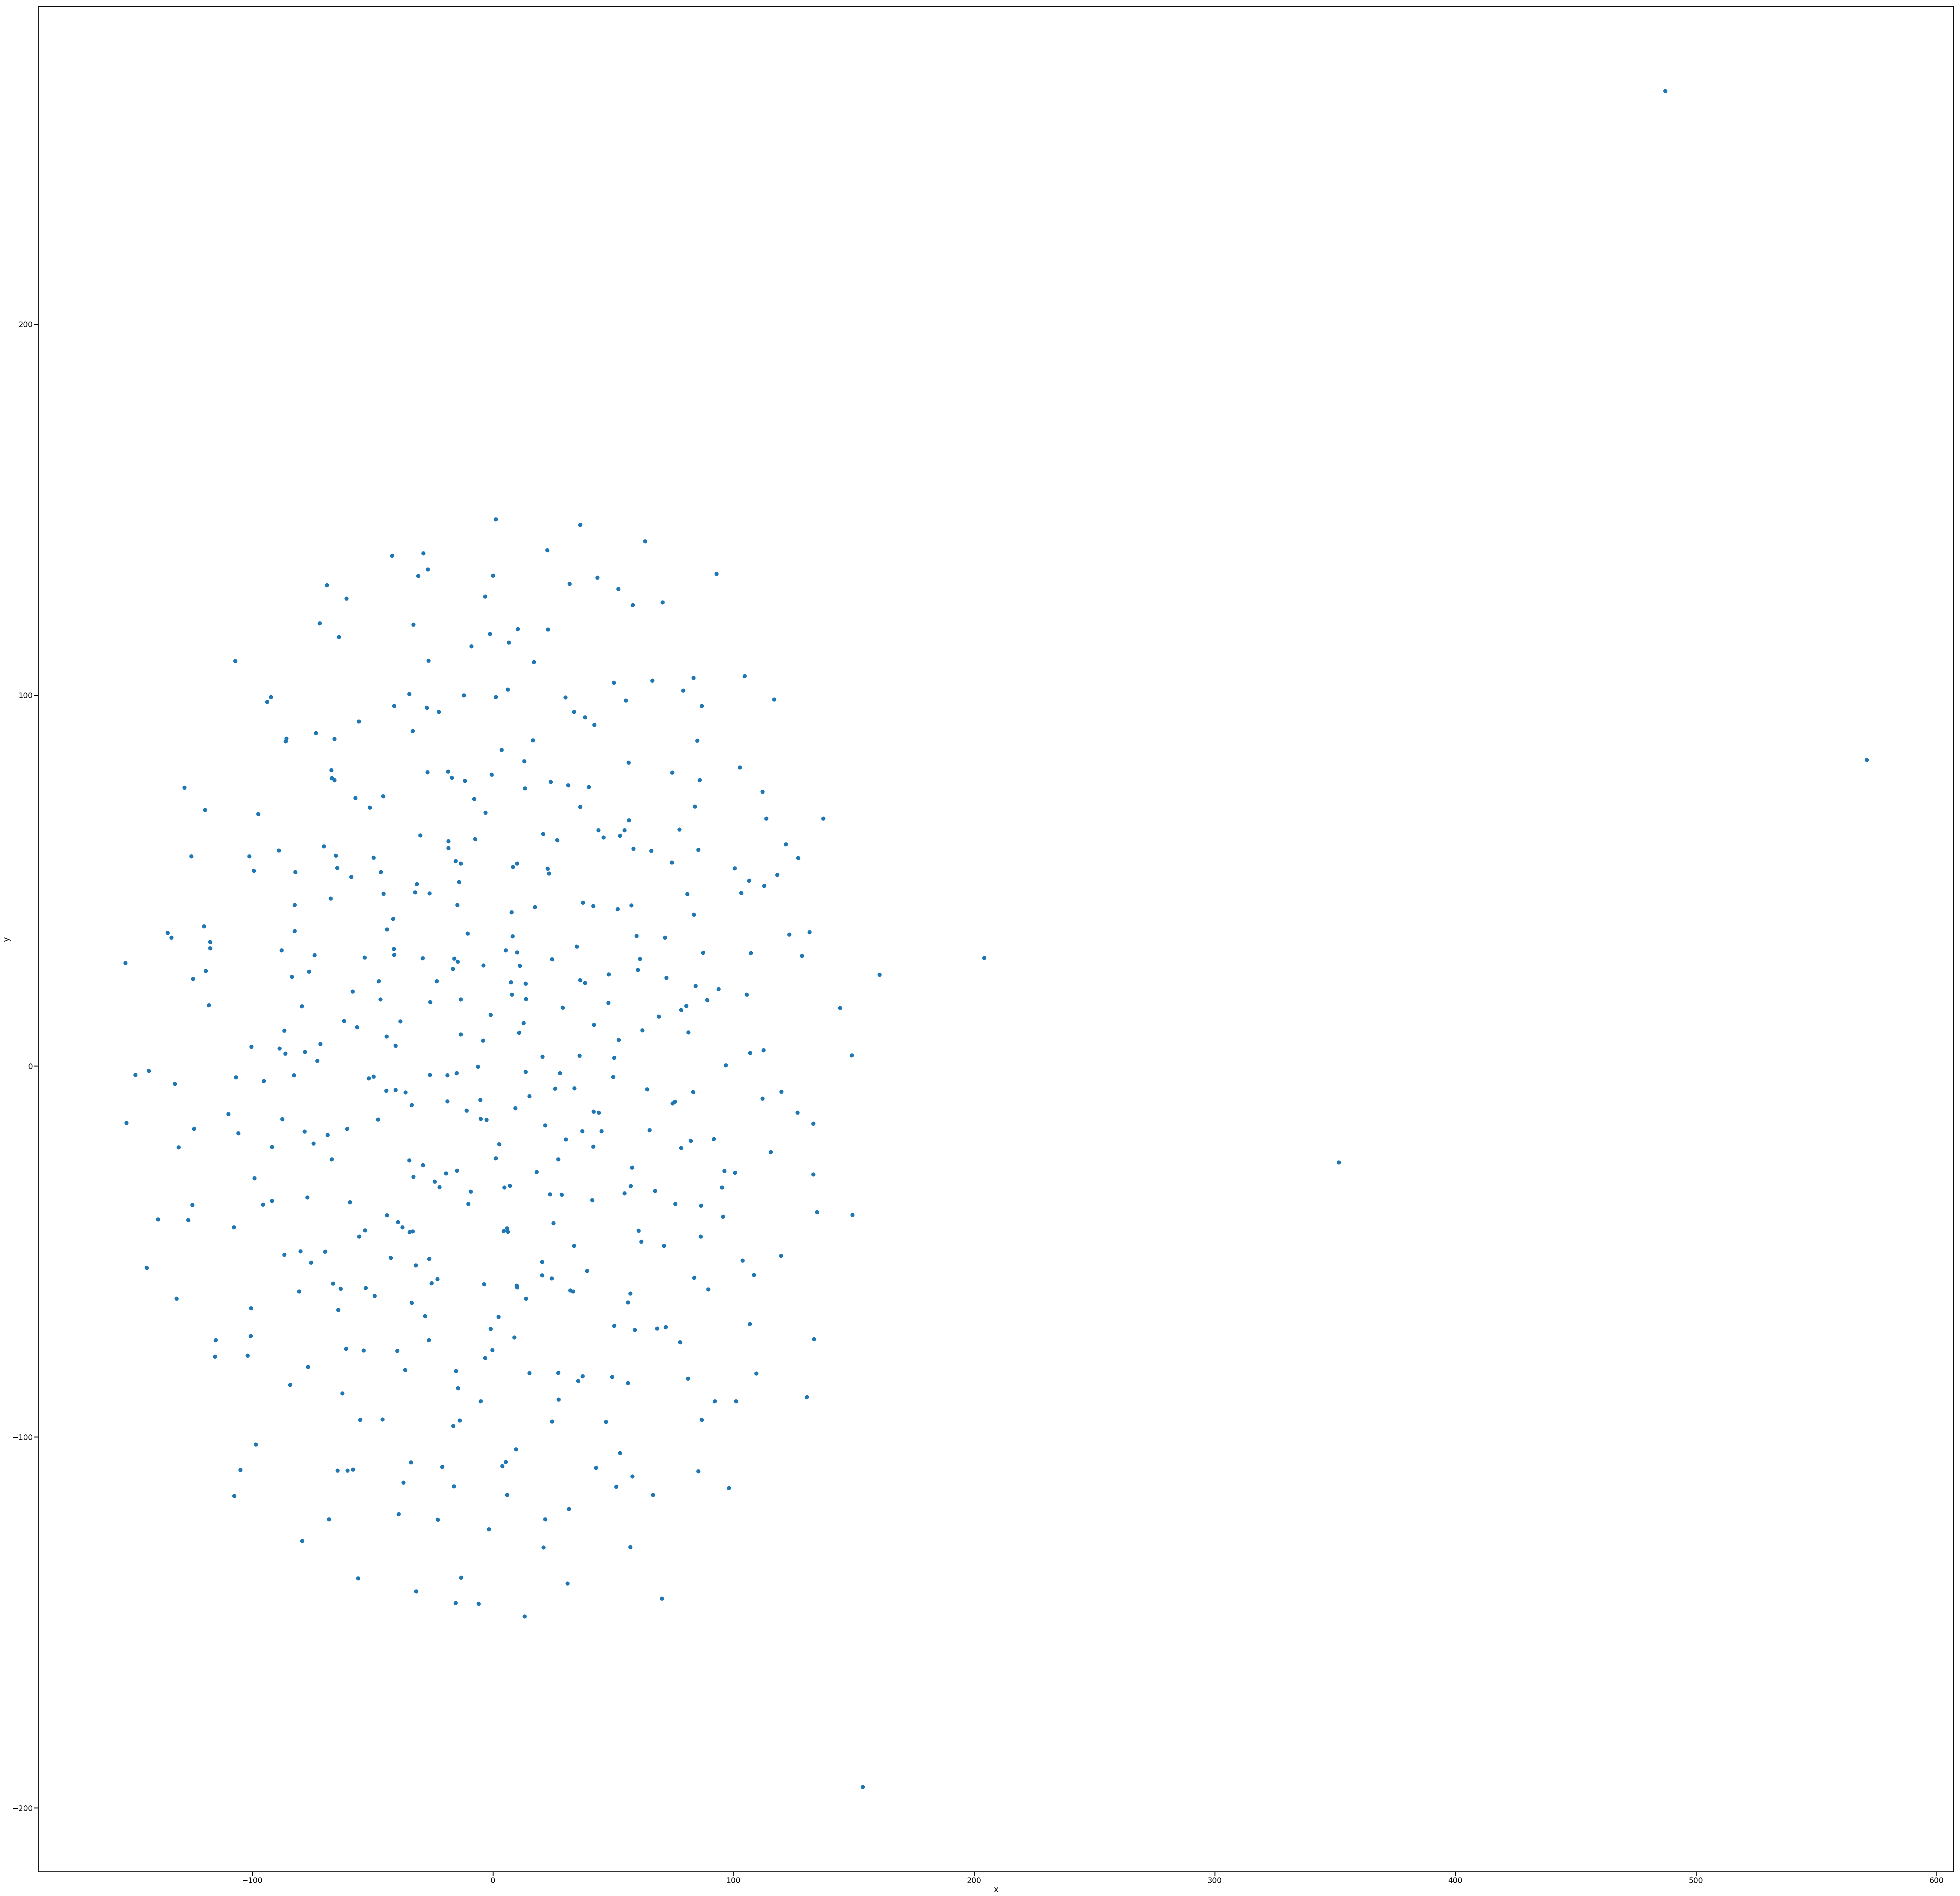

In [30]:
points.plot.scatter("x", "y", s=100, figsize=(100, 100))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [31]:
thrones2vec.most_similar("Wirtschaft")

/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Ausnutzung', 0.7126645445823669),
 ('Mitteln', 0.6176087856292725),
 ('bestimmt', 0.6033012270927429),
 ('Forderungen', 0.594092607498169),
 ('entscheidend', 0.5862294435501099),
 ('Stoff', 0.5837565660476685),
 ('Maschine', 0.5580666065216064),
 ('Selbstzweck', 0.5370772480964661),
 ('Zeit', 0.5211641788482666),
 ('Buches', 0.512017011642456)]

In [32]:
thrones2vec.most_similar("Bauhaus")

/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Weimar', 0.5885417461395264),
 ('unter', 0.5665290355682373),
 ('begonnen', 0.5632935762405396),
 ('hat', 0.551292359828949),
 ('Staatlichen', 0.5389646291732788),
 ('Das', 0.5387405157089233),
 ('Grossherzoglich', 0.5184320211410522),
 ('Arbeiten', 0.5175994634628296),
 ('ehemaligen', 0.5072939395904541),
 ('Sammlung', 0.5006350874900818)]

In [33]:
thrones2vec.most_similar("Studierenden")

/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Mitarbeit', 0.6570457220077515),
 ('Bildhauer', 0.6563683748245239),
 ('Arbeiten', 0.647580087184906),
 ('kuenstlerische', 0.6439590454101562),
 ('Maler', 0.6382704973220825),
 ('sollen', 0.62149977684021),
 ('lassen', 0.6088078022003174),
 ('Meistern', 0.5994886755943298),
 ('Schaffen', 0.5985237956047058),
 ('fremden', 0.5960114002227783)]

**Linear relationships between word pairs**

In [34]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [35]:
nearest_similarity_cosmul("Bauhaus", "Weimar", "Studierenden")
nearest_similarity_cosmul("Bauhaus", "Weimar", "Architekten")
nearest_similarity_cosmul("Form", "Tempo", "Meister")

Bauhaus is related to Weimar, as umfassende is related to Studierenden
Bauhaus is related to Weimar, as will is related to Architekten
Form is related to Tempo, as Architekten is related to Meister


/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'Architekten'

In [36]:
thrones2vec.most_similar(positive=['Bauhaus'], negative=['Studierenden'])

/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('alte', 0.32926851511001587),
 ('hat', 0.30989623069763184),
 ('Umfang', 0.2603083848953247),
 ('war', 0.25711822509765625),
 ('Im', 0.2553393840789795),
 ('Leben', 0.24919335544109344),
 ('dagegen', 0.24848316609859467),
 ('Das', 0.23502710461616516),
 ('Darstellung', 0.23145410418510437),
 ('Weimar', 0.219789057970047)]

In [37]:
thrones2vec.most_similar(positive=['Lehre'], negative=['Meister'])

/home/keno/.conda/envs/w2v/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Grund', 0.43894219398498535),
 ('stofflichen', 0.38306185603141785),
 ('Kenntnis', 0.3398926556110382),
 ('Durchfuehrung', 0.3398502767086029),
 ('bildet', 0.3130481243133545),
 ('alte', 0.30627214908599854),
 ('Versuchsarbeit', 0.281688392162323),
 ('werklichen', 0.2783755362033844),
 ('Wille', 0.27565449476242065),
 ('neuer', 0.27204567193984985)]